In [1]:
# use web page for scraping data about movies or Tv Shows
# collect info about titles, year of realese, genre,runtime..

# etl process
#extract -> automate the scraping process so that it periodicallly pulls updated data
#transform -> clean data, remove unnecessary symbols, whitespace or special characters
#load -> store data in database

# analysis and visualization
# documented

In [2]:
from bs4 import BeautifulSoup as bs
import requests
import pandas as pd
import sqlite3
import sqlalchemy
from sqlalchemy.orm import sessionmaker

In [3]:
url = 'https://onlinesaprevodom.net/category/movies/?order=rating'
page = requests.get(url)

soup = bs(page.content, 'html.parser')

In [4]:
def clean_data(movie):
    movie["name"] = movie["name"].strip()
    movie["genre"] = movie["genre"].strip()
    movie["date"] = movie["date"].strip()
    movie["runtime"] = movie["runtime"].strip()
    return movie

In [5]:
# web scraping part
movies = soup.find_all("div", class_="item-details-inner")
movies_list = []

for movie in movies:
    name = movie.find("h2", class_="movie-title").get_text()
    genre_name = movie.find("div",class_="watch-btn").find("span", class_="genre")
    genre = genre_name.get_text() if genre_name else "Missing"
    date = movie.find("div",class_="watch-btn").find("span", class_="movie-date").get_text()
    runtime = movie.find("div",class_="watch-btn").find("span", class_="runtime").get_text()
    
    movie = {
        "name": name,
        "genre": genre,
        "date" : date,
        "runtime": runtime
    }

    movie = clean_data(movie)
    movies_list.append(movie)


In [6]:
movies_df = pd.DataFrame(movies_list, columns=["name", "genre", "date", "runtime"])
movies_df.head()

,name,genre,date,runtime
0,Camino,Comedy,2023,102 min
1,The Sounding,Drama,2017,93 min
2,Big Nunu’s Little Heist,Comedy,2023,91 min
3,Year One: A Political Odyssey,Documentary,2022,90 min
4,Tantrum,Drama,2021,48 min


In [7]:
engine = sqlalchemy.create_engine("sqlite:///moviesDB.db", echo=True)
connection = sqlite3.connect('db.sqlite')
cur = connection.cursor()


In [8]:
sql_query = """
    CREATE TABLE IF NOT EXISTS movies(
        name VARCHAR(200),
        genre VARCHAR(200),
        date VARCHAR(128),
        runtime VARCHAR(64)
    )
"""

cur.execute(sql_query)
print("Database opened")
try:
    movies_df.to_sql("movies", engine, index=False, if_exists='append')
except:
    print("Data already exists in the database")

Database opened
2024-11-05 19:13:35,624 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-11-05 19:13:35,624 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("movies")
2024-11-05 19:13:35,624 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-11-05 19:13:35,624 INFO sqlalchemy.engine.Engine INSERT INTO movies (name, genre, date, runtime) VALUES (?, ?, ?, ?)
2024-11-05 19:13:35,624 INFO sqlalchemy.engine.Engine [generated in 0.00072s] [('Camino', 'Comedy', '2023', '102 min'), ('The Sounding', 'Drama', '2017', '93 min'), ('Big Nunu’s Little Heist', 'Comedy', '2023', '91 min'), ('Year One: A Political Odyssey', 'Documentary', '2022', '90 min'), ('Tantrum', 'Drama', '2021', '48 min'), ('La cera virgen', 'Comedy', '1972', '102 min'), ('La fierecilla domada', 'Comedy', '1956', '80 min'), ('THE QUEST: Nepal', 'Adventure', '2022', '72 min')  ... displaying 10 of 24 total bound parameter sets ...  ('Bulldog', 'Drama', '2023', '95 min'), ('Lhamo and Skalbe', 'Missing', '2019', '110 min')]
202

In [9]:
connection.close()
print("Connection closed")

Connection closed


In [10]:
# Checking data in table 'movies'
with engine.connect() as connection:
    df2 = pd.read_sql('SELECT * FROM movies', con=connection)
    print("Check first few rows in database:\n", df2.head())

print("Checking has been completed.")

2024-11-05 19:13:35,766 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-11-05 19:13:35,766 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("SELECT * FROM movies")
2024-11-05 19:13:35,767 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-11-05 19:13:35,768 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("SELECT * FROM movies")
2024-11-05 19:13:35,769 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-11-05 19:13:35,769 INFO sqlalchemy.engine.Engine SELECT * FROM movies
2024-11-05 19:13:35,770 INFO sqlalchemy.engine.Engine [raw sql] ()
Check first few rows in database:
                             name        genre  date  runtime
0                         Camino       Comedy  2023  102 min
1                   The Sounding        Drama  2017   93 min
2        Big Nunu’s Little Heist       Comedy  2023   91 min
3                        Tantrum        Drama  2021   48 min
4  Year One: A Political Odyssey  Documentary  2022   90 min
2024-11-05 19:13:35,773 INFO sqlalchemy.engine.Eng

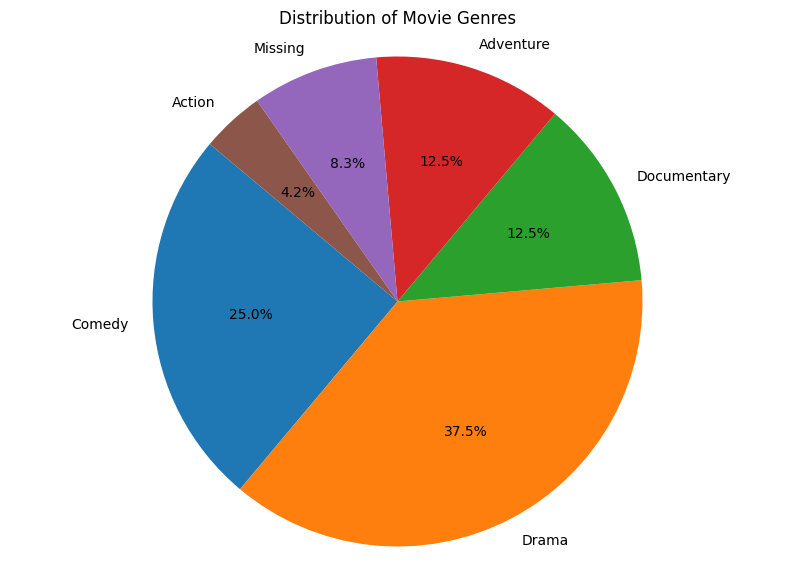

In [11]:
import matplotlib.pyplot as plt
from collections import Counter

genre_counts = Counter(movie['genre'] for movie in movies_list)
labels = genre_counts.keys()
sizes = genre_counts.values()

plt.figure(figsize=(10, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular.
plt.title('Distribution of Movie Genres')
plt.show()

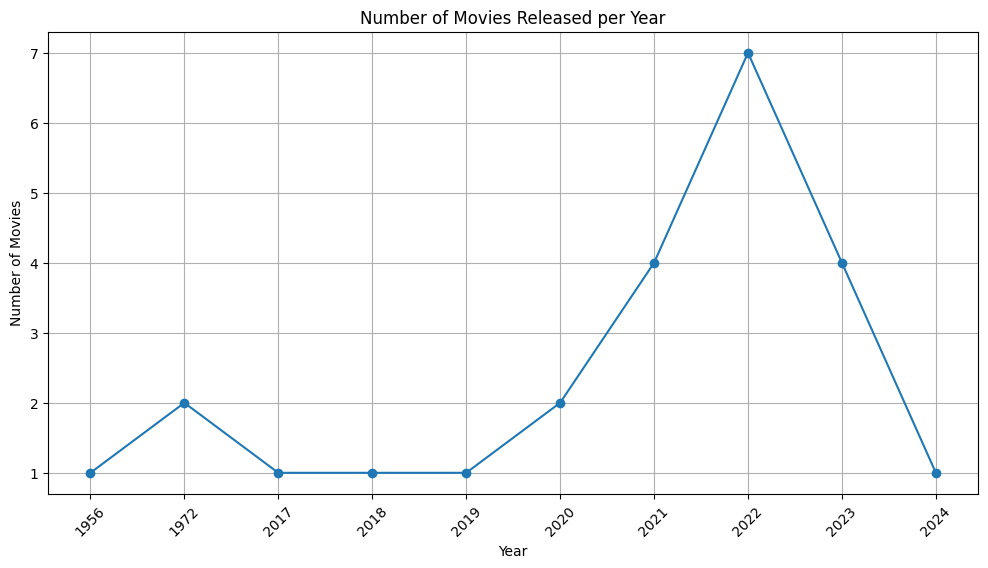

In [12]:
release_years = [movie['date'] for movie in movies_list]
year_counts = Counter(release_years)
df = pd.DataFrame(year_counts.items(), columns=['Year', 'Count']).sort_values('Year')

# Create line graph
plt.figure(figsize=(12, 6))
plt.plot(df['Year'], df['Count'], marker='o')
plt.xticks(rotation=45)
plt.title('Number of Movies Released per Year')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.grid()
plt.show()